<a href="https://colab.research.google.com/github/priyansh-shankhdhar/Pneumonia-detection-using-chest-x-ray/blob/master/chest_x_ray_with_great_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-ray dataset with 98.5% accuracy on test data

**Adding all the required header files at first**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
%matplotlib inline

**Now we initialize the dataset directories**

here we also get all the file names inside each path 

In [ ]:
path_normal_train='../input/chest-xray-pneumonia/chest_xray/train/NORMAL'
j_n=os.listdir(path_normal_train)
path_pneumonia_train='../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
j_p=os.listdir(path_pneumonia_train)

# Visualising images

**Visualising how are the x-ray images inside the dataset with 2 images show of each category i.e Normal and Pnemonia**

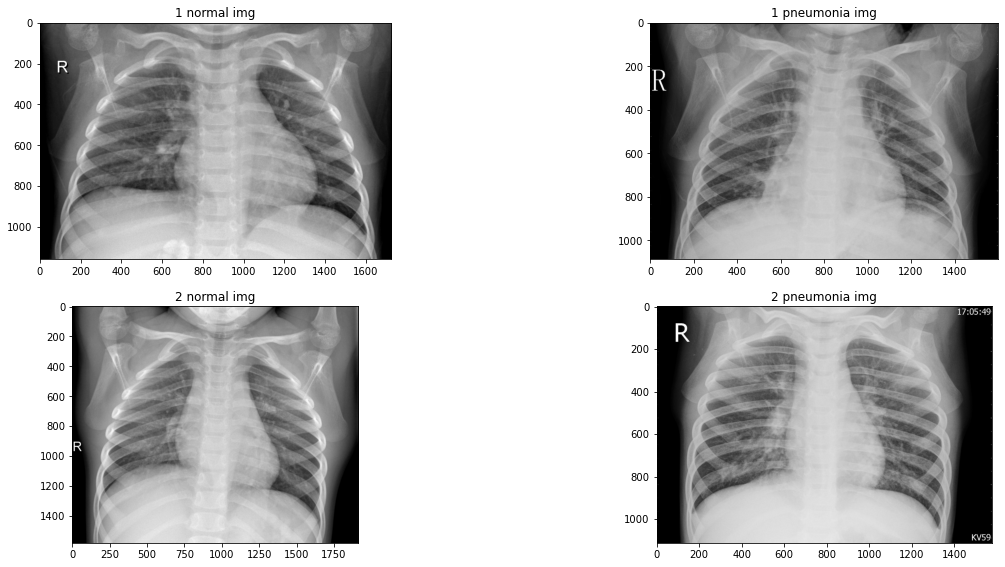

In [ ]:
fig=plt.figure(figsize=(20,20))
o=1
for i in range(2):
    fig.add_subplot(4,2,o)
    plt.title(str(i+1)+' normal img')
    j=cv2.imread(os.path.join(path_normal_train,j_n[i]))
    plt.imshow(j)
    o+=1
    fig.add_subplot(4,2,o)
    plt.title(str(i+1)+' pneumonia img')
    j=cv2.imread(os.path.join(path_pneumonia_train,j_p[i]))
    plt.imshow(j)
    o+=1
plt.show()

**Plotting the no. of images in test dataset**

Text(0, 0.5, 'no. of images')

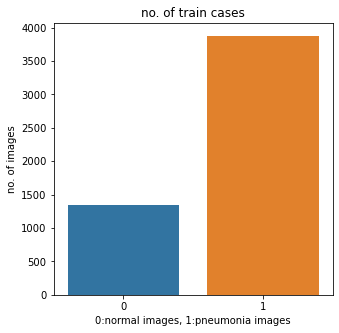

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(x=[0,1], y= [len(j_n),len(j_p)])
plt.title('no. of train cases')
plt.xlabel('0:normal images, 1:pneumonia images')
plt.ylabel('no. of images')

# Data Augmentation
Because the images in taining data is quite less, and the CNN won't be able to train itself properly thus we need to create augmented data.


**What is data Augmentaion?**
Limited data is a major obstacle in applying deep learning models like convolutional neural networks. Often, imbalanced classes can be an additional hindrance; while there may be sufficient data for some classes, equally important, but undersampled classes will suffer from poor class-specific accuracy. This phenomenon is intuitive. If the model learns from a few examples of a given class, it is less likely to predict the class invalidation and test applications.


Here is the index of techniques people use for augmenting data:
* Scaling
* Translation
* Rotation (at 90 degrees)
* Rotation (at finer angles)
* Flipping
* Adding Salt and Pepper noise
* Lighting condition
* Perspective transform

Thus, below with the help of [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class. I have augmented the data.

In [ ]:
gen=ImageDataGenerator(rotation_range=20,width_shift_range=0.1,
                       height_shift_range=0.1,shear_range=0.15,
                       zoom_range=0.1,channel_shift_range=10,horizontal_flip=True,vertical_flip=True,
                       fill_mode='constant',cval=125)

# Visualising augmented data

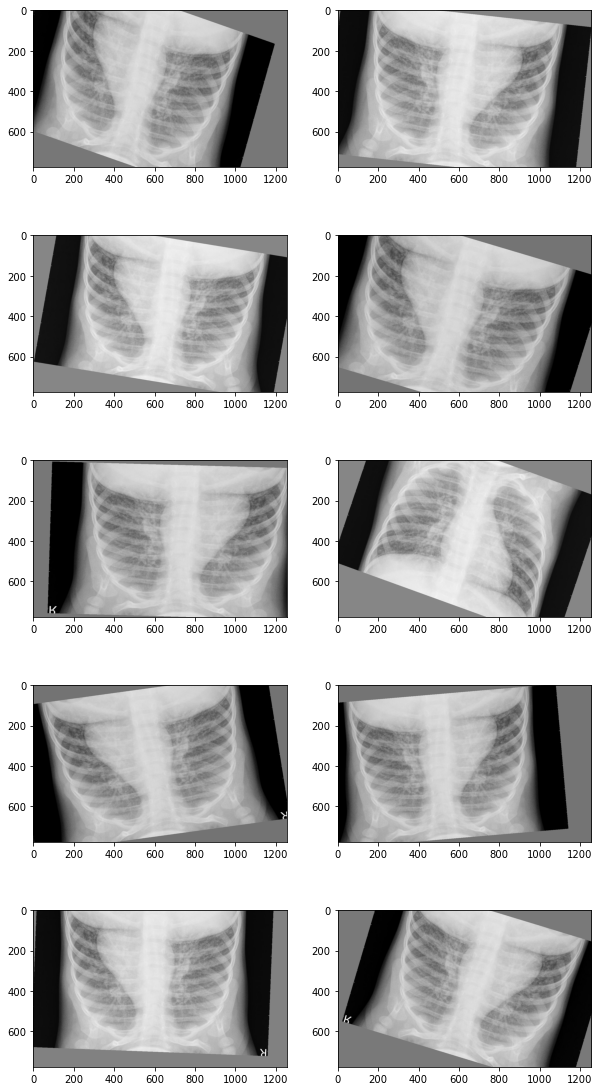

In [ ]:
#below function plots the  
def plots(figsize,images,a,b):
    fig=plt.figure(figsize=figsize)
    for i in range(1,len(images)+1):
        fig.add_subplot(a,b,i)
        plt.imshow(images[i-1])
    plt.show()
               
        
def create_images(path,j_p,i,pri):
    img_path=os.path.join(path,j_p[i])
    image=np.expand_dims(cv2.imread(img_path),0)
    aug_itter=gen.flow(image)#,save_to_dir=path,save_prefix='aug',save_format='jpeg')
    aug_images=[next(aug_itter)[0].astype(np.uint8) for i in range(10)]
    if pri=='print':
        plots((10,20),aug_images,5,2)


#takes-> path of directory, 
#        images_name_list, 
#        which image(i'th image),
#       'print' if want to print images else empty with ""    
create_images(path_pneumonia_train,j_p,3,'print')

**Applying the Image data generator library to get the data from directories**

**Loaded datasets are:**
* train data
* augmented test data
* validation data
* test data

In [ ]:
train_='../input/chest-xray-pneumonia/chest_xray/train'
test_='../input/chest-xray-pneumonia/chest_xray/test'
val_='../input/chest-xray-pneumonia/chest_xray/val'

#loads train_data
train_gen=ImageDataGenerator(rescale=1./255)
train=train_gen.flow_from_directory(train_,
                                   target_size=(250,250),
                                   batch_size=10,
                                   class_mode='binary')


#loads augmented load_data
augmentation=ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.1,
                       height_shift_range=0.1,shear_range=0.15,
                       zoom_range=0.1,channel_shift_range=10,horizontal_flip=True,vertical_flip=True,
                       fill_mode='constant',cval=125)
train_augmentation=augmentation.flow_from_directory(train_,
                                target_size=(250,250),
                                batch_size=10,
                                class_mode='binary')


#loads test data
test_gen=ImageDataGenerator(rescale=1./255)
test=test_gen.flow_from_directory(test_,
                                  target_size=(250,250),
                                  batch_size=10,
                                  class_mode='binary')


#loads validaiton data
val_gen=ImageDataGenerator(rescale=1./255)
val=val_gen.flow_from_directory(test_,
                                target_size=(250,250),
                                batch_size=10,
                                class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Creating the model

In [ ]:

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(250,250,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,activation='sigmoid'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 256)       2

In [ ]:
from keras.optimizers import Adam
opt=Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])

#this function plots the graph between train and validation data parameters
def plot_metrics(history,epochs):
    epoch=range(1,epochs+1)
    loss=history.history['loss']
    accuracy=history.history['acc']
    vlos=history.history['val_loss']
    vacc=history.history['val_acc']
    plt.title('Loss graph')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(epoch,loss)
    plt.plot(epoch,vlos)
    plt.show()
    plt.title('Accuracy graph')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(epoch,accuracy)
    plt.plot(epoch,vacc)
    plt.show()

**At first we fir aur augmented data**

In [ ]:
epochs=30
history=model.fit_generator(train_augmentation,
                            steps_per_epoch=20,
                            epochs=epochs,
                            validation_data=val,
                            validation_steps=8,
                            verbose=1)

Epoch 1/30
20/20 [==============================] - 10s 515ms/step - loss: 0.6276 - acc: 0.7050 - val_loss: 0.3871 - val_acc: 0.8625
Epoch 2/30
20/20 [==============================] - 10s 512ms/step - loss: 0.4170 - acc: 0.8100 - val_loss: 0.3452 - val_acc: 0.8625
Epoch 3/30
20/20 [==============================] - 10s 485ms/step - loss: 0.4220 - acc: 0.8050 - val_loss: 0.3760 - val_acc: 0.8500
Epoch 4/30
20/20 [==============================] - 9s 467ms/step - loss: 0.5501 - acc: 0.7150 - val_loss: 0.4828 - val_acc: 0.8000
Epoch 5/30
20/20 [==============================] - 11s 546ms/step - loss: 0.5391 - acc: 0.7150 - val_loss: 0.3830 - val_acc: 0.7875
Epoch 6/30
20/20 [==============================] - 10s 491ms/step - loss: 0.5037 - acc: 0.7450 - val_loss: 0.3017 - val_acc: 0.8750
Epoch 7/30
20/20 [==============================] - 10s 492ms/step - loss: 0.4201 - acc: 0.8050 - val_loss: 0.3884 - val_acc: 0.8625
Epoch 8/30
20/20 [==============================] - 10s 486ms/step - l

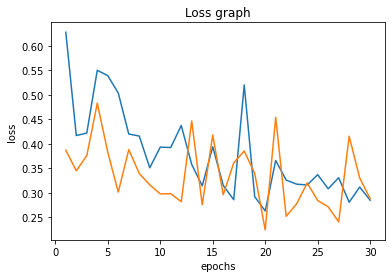

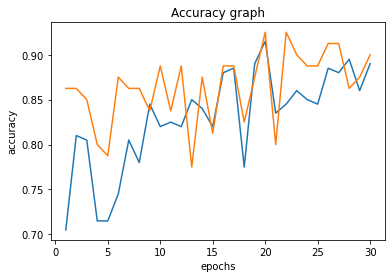

In [ ]:
plot_metrics(history,epochs)

**We can see from the above graph that the data is not over fitting and augmeted data is giving good results, thus now we train the same model with same trained parameters but with test dataset which is not augmented**

In [ ]:
history=model.fit_generator(train,
                            steps_per_epoch=20,
                            epochs=epochs,
                            validation_data=val,
                            validation_steps=8,
                            verbose=1)

Epoch 1/30
20/20 [==============================] - 8s 387ms/step - loss: 0.2672 - acc: 0.8700 - val_loss: 0.4867 - val_acc: 0.8250
Epoch 2/30
20/20 [==============================] - 7s 361ms/step - loss: 0.1942 - acc: 0.9200 - val_loss: 0.3246 - val_acc: 0.8625
Epoch 3/30
20/20 [==============================] - 7s 374ms/step - loss: 0.1410 - acc: 0.9550 - val_loss: 0.4770 - val_acc: 0.8375
Epoch 4/30
20/20 [==============================] - 8s 376ms/step - loss: 0.1356 - acc: 0.9643 - val_loss: 0.4662 - val_acc: 0.8500
Epoch 5/30
20/20 [==============================] - 7s 365ms/step - loss: 0.1553 - acc: 0.9600 - val_loss: 0.4529 - val_acc: 0.8375
Epoch 6/30
20/20 [==============================] - 7s 353ms/step - loss: 0.1681 - acc: 0.9450 - val_loss: 0.6070 - val_acc: 0.8000
Epoch 7/30
20/20 [==============================] - 7s 360ms/step - loss: 0.1438 - acc: 0.9541 - val_loss: 0.4498 - val_acc: 0.8250
Epoch 8/30
20/20 [==============================] - 7s 369ms/step - loss: 0.

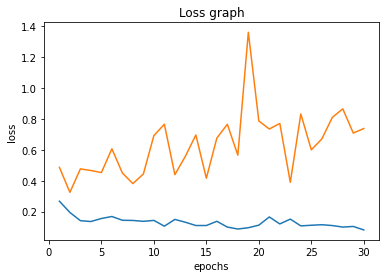

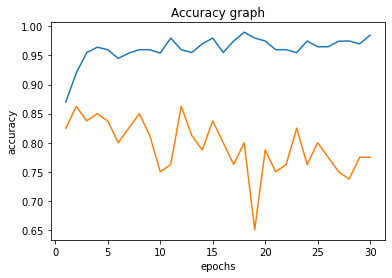

In [ ]:
plot_metrics(history,epochs)

**The training accuracy is great with 98.5% but this decreased the validation accuracy. From the graphs we can see that the dataset is overfitting thus we again train the same model with previous augmented data but for less no. of epochs(15)**

In [ ]:
epochs=15
history=model.fit_generator(train_augmentation,
                            steps_per_epoch=20,
                            epochs=epochs,
                            validation_data=val,
                            validation_steps=8,
                            verbose=1)

Epoch 1/15
20/20 [==============================] - 11s 529ms/step - loss: 0.3792 - acc: 0.8650 - val_loss: 0.4728 - val_acc: 0.8125
Epoch 2/15
20/20 [==============================] - 10s 523ms/step - loss: 0.2919 - acc: 0.8750 - val_loss: 0.7628 - val_acc: 0.7250
Epoch 3/15
20/20 [==============================] - 10s 523ms/step - loss: 0.3211 - acc: 0.8550 - val_loss: 0.2801 - val_acc: 0.8375
Epoch 4/15
20/20 [==============================] - 10s 516ms/step - loss: 0.3327 - acc: 0.8650 - val_loss: 0.2408 - val_acc: 0.8875
Epoch 5/15
20/20 [==============================] - 11s 533ms/step - loss: 0.3177 - acc: 0.8469 - val_loss: 0.4962 - val_acc: 0.7625
Epoch 6/15
20/20 [==============================] - 10s 500ms/step - loss: 0.3177 - acc: 0.8400 - val_loss: 0.3991 - val_acc: 0.8750
Epoch 7/15
20/20 [==============================] - 11s 526ms/step - loss: 0.3533 - acc: 0.8300 - val_loss: 0.4116 - val_acc: 0.7875
Epoch 8/15
20/20 [==============================] - 11s 536ms/step - 

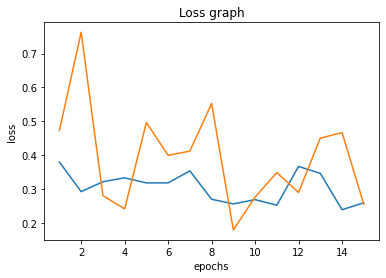

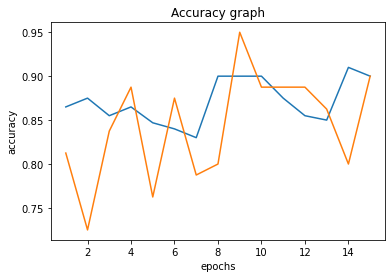

In [ ]:
plot_metrics(history,epochs)

# Done training

Now we try to predict the test data. 

we get an accuracy of 86% at the test data

In [ ]:
loss, acc = model.evaluate_generator(test, steps=3, verbose=1)

3/3 [==============================] - 0s 154ms/step - loss: 0.3511 - acc: 0.8667


# Here is the block visualisation of the model

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)